In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project import Project
import scipy.optimize

In [7]:
def get_loading(job):
    fn = job.fn('hpmc-muvt-stats.txt')
    data = np.genfromtxt(fn, names=True)
    return data['timestep'], data['hpmc_muvt_N_B']

def plot_loading(job, figax=None, **kwargs):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    title = kwargs.get('title', None)
    ts, N = get_loading(job)
    ax.plot(ts, N, label=f'{job.sp.fugacity}, {job.sp.guest_aspect_ratio}')
    ax.legend(title='fugacity, r')
    ax.set_xlabel('hpmc step')
    ax.set_ylabel('N guests')
    ax.set_title(title)
    return fig, ax

def fractional_loading(job):
    n_pores = job.sp.n_repeats[0] * job.sp.n_repeats[1]
    ts, N = get_loading(job)
    mean_N = np.mean(N[-10:])
    return mean_N / n_pores

def langmuir_isotherm(fugacity, P0):
    return fugacity / (fugacity + P0)

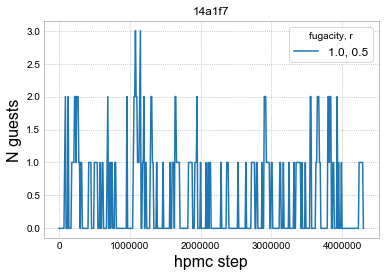

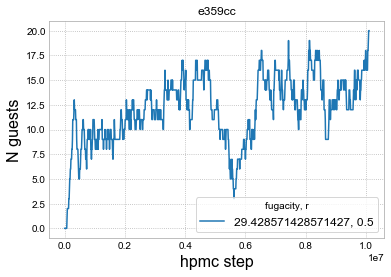

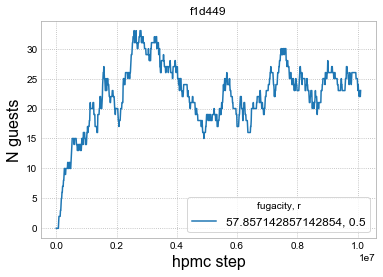

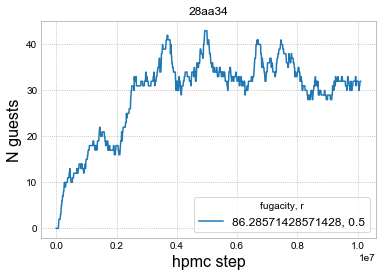

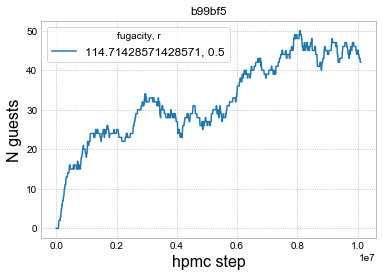

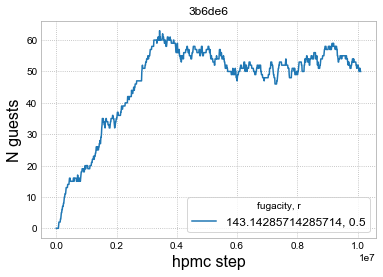

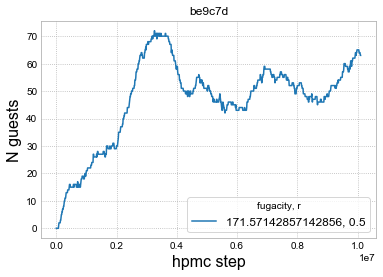

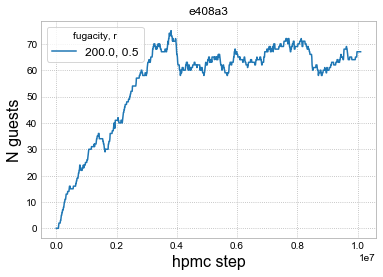

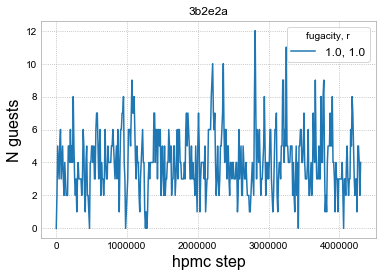

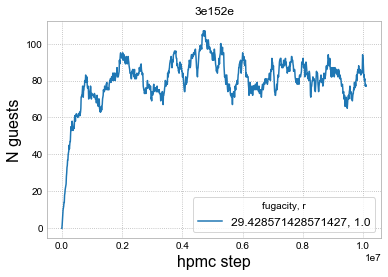

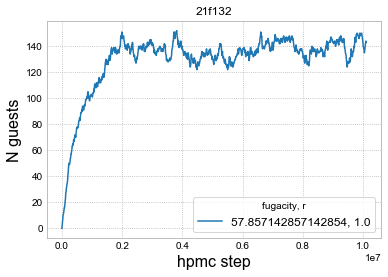

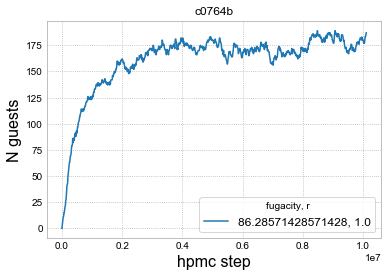

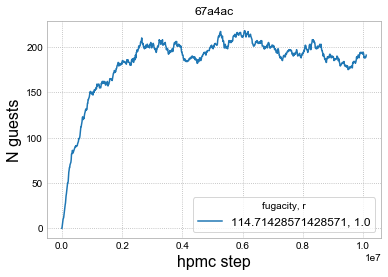

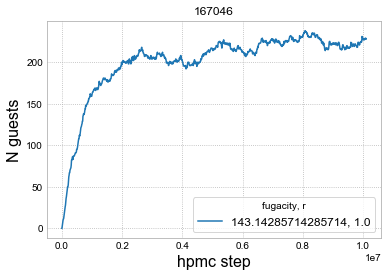

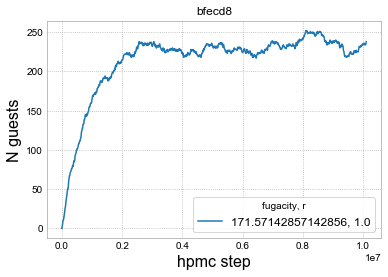

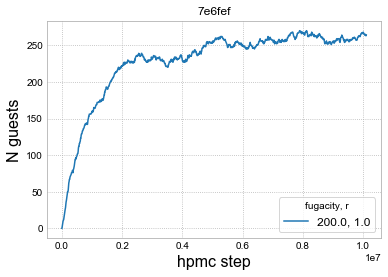

In [8]:
pr = Project()
loading_data = {}
gb = ['guest_aspect_ratio', 'fugacity']
jf = {'host_guest_area_ratio': 0.4}
for params, jobs in pr.find_jobs(jf).groupby(gb):
    gar, fug = params
    loading_data.setdefault(gar, [])
    for job in jobs:
        if job.doc.get('timestep', -1) < 0:
            continue
        fig, ax = plot_loading(job, title=job._id[:6])
        loading_data[gar].append((fug, fractional_loading(job)))

0.5 [954.14969593]
1.0 [112.12389244]


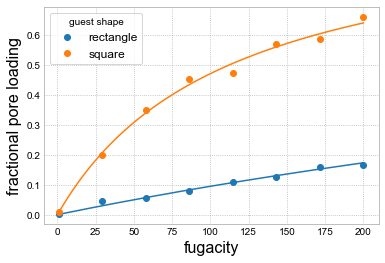

In [11]:
fig, ax = plt.subplots()
shapes = {0.5: 'rectangle', 1.0: 'square'}
for gar, gardata in loading_data.items():
    if len(gardata) < 2:
        continue
    fugacity, loading = np.array(gardata).T
    shape = shapes[gar]
    ll, = ax.plot(fugacity, loading, 'o', label=shape)
    popt, pcov = scipy.optimize.curve_fit(langmuir_isotherm, fugacity, loading)
    fit_fug = np.linspace(np.amin(fugacity), np.amax(fugacity), 1000)
    fit_loading = langmuir_isotherm(fit_fug, *popt)
    ax.plot(fit_fug, fit_loading, c=ll.get_c())
    print(gar, popt)
legend = ax.legend(title='guest shape')
xlabel = ax.set_xlabel('fugacity')
ylabel = ax.set_ylabel('fractional pore loading')
fig.set_facecolor('w')

[ 961024.01259532 2209672.28804787]


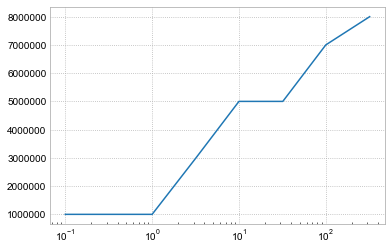

In [20]:
data = [
    (0.1, 1e6),
    (0.32, 1e6),
    (1.0, 1e6),
    (3.2, 3e6),
    (10, 5e6),
    (32, 5e6),
    (100, 7e6),
    (320, 8e6)
]
f, t = np.array(data).T
fig, ax = plt.subplots()
ax.semilogx(f, t)
p = np.polyfit(np.log(f), t, 1)
print(p)